Author: Ben Garrett
Created Date: 03/23/2021

*The following article is written as a Jupyter Notebook. All code can be run and tweaked by clicking the 'Open in Colab' button. Although it can be opend in Colab, the dataset and models utilized in this demo are too large to run with Colab's free-tier hardware constraints*

# Introduction

In this demonstration, I will compare several different models that can be used for time series analysis. Time series data is a unique type of data where observations are recorded at discrete points in time. Forecasting the future is one of the most relavant ways to utilize machine learning and statistics in  a business context. These forecasts could be predicting future sales, demand load in a electric grid, the next word or sentence in a text auto-complete product or anything else. In this project, I will use historical tide height measurements to build four types of time series forecasting models. Although empirical equations have been developed to predict tides with acceptable accuracy already, this dataset provides a great opportunity to test out different model architectures on a complex yet solvable mathematical problem with reasonable runtime for experimentation. Although this is a 'solved' problem, I learned that NOAA's tide predictions are not as perfect as I expected with typical RMSE's of 20 to 150 mm ([read more here](https://tidesandcurrents.noaa.gov/pdf/Tide_Prediction_Error_for_the_United_States_Coastline.pdf)). These errors will be used as a general benchmark for the models I build.

Models used in this project:
- XG Boost boosted tree model
- Convolutional Neural Network (CNN)
- Long Short-Term Memory Neural Network (LSTM)
- Simple Statistical Autoregression Model

These models will be built to predict hourly tide heights for the next 7 days given a chunk of historical observations. 


## Background

Tides are caused by gravitational forces of the moon, and to a lesser extent, the sun. Additionally, local tides are controlled by coastline geography and bathymetry (surbsurface depth and shape). Local weather can also play a significant role as high and low pressure systems exert different displacement forces on the ocean's surface. Although we can predict moon and sun position with high accuracy, the abiity to map the ocean's sub-surface at large scale and with high resolution is very new. The NOAA predicts tides using years of historical data and fairly sophisticated sine-wave algorithms that are tuned to a local vertical sea level datum. More information about the current NOAA methodology can be found here:

https://tidesandcurrents.noaa.gov/restles1.html

Their method does not use machine learning. The goal of this project is not specifically to improve their method. This is a solved problem and this project simply aims to demonstrate the use of behavior of several models for predicting multi-scale trends. 

## The Data

Tides have been recorded in many harbors for centuries. Thus, there is an abundance of available tide height data for most port cities around the world. I choose to use a dataset of hourly ocean height measurements since 1911 for the Victoria, BC harbor. The dataset source is: 

http://uhslc.soest.hawaii.edu/data/

Caldwell, P. C., M. A. Merrifield, P. R. Thompson (2015), Sea level measured by tide gauges from global oceans — the Joint Archive for Sea Level holdings (NCEI Accession 0019568), Version 5.5, NOAA National Centers for Environmental Information, Dataset, doi:10.7289/V5V40S7W.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import datetime
from statsmodels.tsa.ar_model import AutoReg

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('Ready to Go!')

Ready to Go!


## Get the Data

The data can be accessed from my Github page. The following code gets the tabular dataset. Tide measurements are in mm. The dataset contains many null/bad values (value for bad data is -32767). The machine learning models used here take sequences of historical data and make predictions from them. Thus, as you will see below, historical sequences with these bad values will be excluded from the training datasets. The autoregression model needs a much longer history than the others to produce similar accuracy, thus it was impossible to simply drop sequences with these values. For that model, the bad values were simple deleted from the training dataset. This is not ideal, and in a final, deployable system I would build a sub-model to interpolate the bad values before training the final model.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/bimewok/predicting_tides/main/data/tides.csv')
df = df.fillna(-32767)
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

data = np.array(df['height'])

results = pd.DataFrame(columns=['model', 'mae', 'runtime'])
num_to_show = 20 # number of charts to produce to visualize predictions for each of the models

np.random.seed(42)
tf.random.set_seed(42)

display(df[242358:242368])

,year,month,day,hour,height,date
242358,1936,10,12,15,1370,1936-10-12 15:00:00
242359,1936,10,12,16,1461,1936-10-12 16:00:00
242360,1936,10,12,17,1674,1936-10-12 17:00:00
242361,1936,10,12,18,1857,1936-10-12 18:00:00
242362,1936,10,12,19,2040,1936-10-12 19:00:00
242363,1936,10,12,20,2193,1936-10-12 20:00:00
242364,1936,10,12,21,2315,1936-10-12 21:00:00
242365,1936,10,12,22,2284,1936-10-12 22:00:00
242366,1936,10,12,23,2162,1936-10-12 23:00:00
242367,1936,10,13,0,1979,1936-10-13 00:00:00


## Visualize Trends

Here we will look at two charts: <br>
1) Average tide height across all dates on a daily, weekly, annual and all time basis. This will show us global trends in the data. <br>
2) Visualization of a random day, week, month of sequential data. 

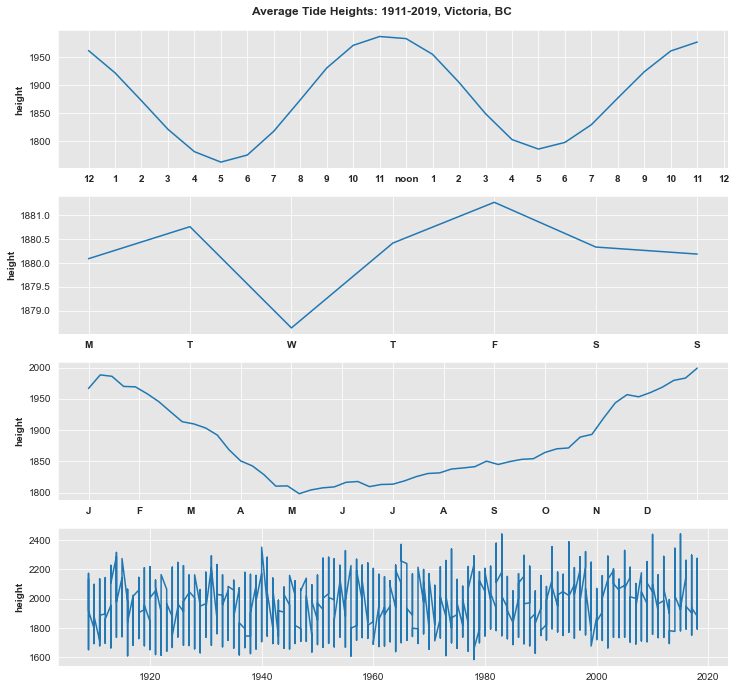

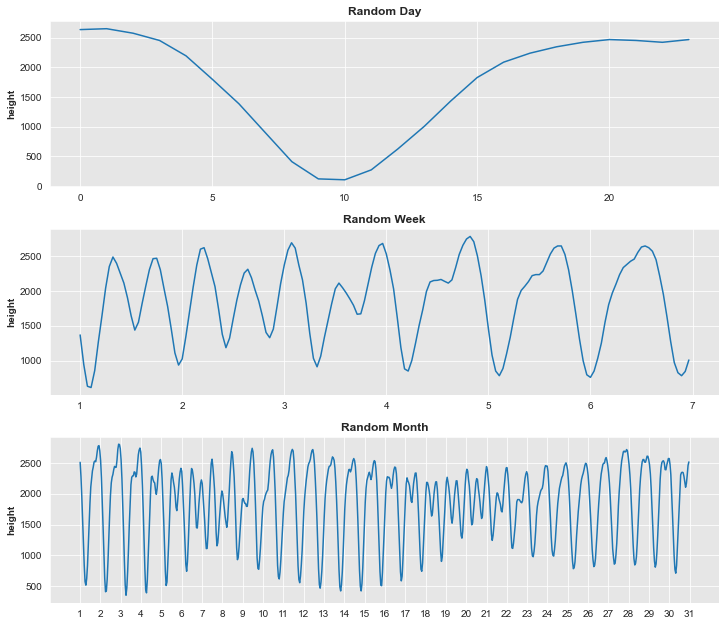

In [3]:
def vis_global_avgs(data=df[df['height'] != -32767]):
    day_of_week_means = pd.DataFrame(
        data.groupby([data['date'].dt.dayofweek]).mean())
    
    time_of_day_means = pd.DataFrame(
        data.groupby([data['date'].dt.hour, data['date'].dt.minute]).mean())
    
    yearly_change_means = pd.DataFrame(
        data.groupby(
            [data['date'].dt.year, data['date'].dt.isocalendar().week]
        ).mean())
    
    annual_means = pd.DataFrame(data.groupby([data['date'].dt.isocalendar().week]).mean())
    
    day_of_week_means['series'] = np.arange(len(day_of_week_means))
    
    time_of_day_means['series'] = np.arange(len(time_of_day_means))
    
    yearly_change_means['series'] = np.arange(len(yearly_change_means))
    annual_means['series'] = np.arange(float(len(annual_means)))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
    
    fig.set_size_inches(12, 10.7)
    #fig.subplots_adjust(hspace=0.25)
    fig.suptitle('Average Tide Heights: 1911-2019, Victoria, BC', 
                 fontweight='bold')
    
    fig.subplots_adjust(top=0.95)
    
    
    ax1.plot(time_of_day_means['series'], time_of_day_means['height'])
    ax1.set_xticks([*range(0, 25, 1)])
    ax1.set_xticklabels(['12', '1', '2', '3', '4', '5', '6', '7', '8', 
                         '9', '10', '11', 'noon', '1', '2', '3', '4', 
                         '5', '6', '7', '8', '9', '10', '11', '12'], 
                        fontweight='bold')
    
    ax1.grid(True)
    ax1.set_ylabel('height', fontweight='bold')
    
    ax2.plot(day_of_week_means['series'], day_of_week_means['height'])
    
    
    ax2.set_xticks([*range(0, 7)])
    ax2.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'], fontweight='bold')
    ax2.grid(True)
    ax2.set_ylabel('height', fontweight='bold')
    
    ax3.plot(annual_means['series'], annual_means['height'])
    ax3.set_xticks(np.linspace(0., max(annual_means['series']), num=13))
    ax3.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 
                         'N', 'D', ''], 
                        fontweight='bold')
    
    ax3.grid(True)
    ax3.set_ylabel('height', fontweight='bold')
    
    ax4.plot(yearly_change_means['year'], yearly_change_means['height'])
    ax4.grid(True)
    ax4.set_ylabel('height', fontweight='bold')
    
def vis_random_sequences(data=df[df['height'] != -32767]):
    r = [2928, 373849, 48167]
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_size_inches(12, 10.7)
    ax1.plot(range(0,24), data['height'][r[0]:r[0]+24])
    ax1.set_title('Random Day', fontweight='bold')
    ax1.set_ylabel('height', fontweight='bold')
    
    ax2.plot(range(0,168), data['height'][r[1]:r[1]+168])
    ax2.set_title('Random Week', fontweight='bold')
    ax2.set_ylabel('height', fontweight='bold')
    ax2.set_xticks(np.linspace(0, 168, num=7))
    ax2.set_xticklabels([1, 2, 3, 4, 5, 6, 7])
    
    ax3.plot(range(0,744), data['height'][r[2]:r[2]+744])
    ax3.set_title('Random Month', fontweight='bold')
    ax3.set_ylabel('height', fontweight='bold')
    ax3.set_xticks(np.linspace(0, 744, num=31))
    ax3.set_xticklabels([*range(1, 32, 1)])
   
    fig.subplots_adjust(hspace=0.25)
    plt.show()
    
vis_global_avgs()
vis_random_sequences()

## XG Boost Model

[XG Boost](https://xgboost.readthedocs.io/en/latest/index.html) is a powerful machine learning library that provides an easy interface to several types of gradient-boosted models. Of their models, their boosted tree model is remarkably performant, flexible and fast on many supervised machine learning tasks. 

To predict hourly tide heights for the next 7 days, we need to re-frame the dataset into a supervised format where you have an array X, containing sequences of historical observations and for each sequence an array y, containing the next 168 values. XG Boost does not natively support predicting multiple values for y, thus I built a MultiOutput class that takes in a model and its parameters, and builds a submodel trained to predict each future value in the sequence. 

In [ ]:
start = datetime.datetime.now()

future = 7*24 # want to predict 7 days in future
past = 50*24 # how much historic data will be used to make pred.
train_size = 0.8 # remained will be test set

x = []
y = []

for i in range(len(data)):
    x_append = data[i:i+past]
    y_append = data[i+past:i+past+future]
    if -32767 not in x_append and -32767 not in y_append: 
        x.append(x_append)
        y.append(y_append)
        
x = np.array(x[:-1*(future+past-1)]) 
y = np.array(y[:-1*(future+past-1)])


arr = np.arange(len(x))
np.random.shuffle(arr) # random indices for train split

train_end = int(train_size*len(x))

x_train = x[arr[:train_end]]
x_test = x[arr[train_end:]]


y_train = y[arr[:train_end]]
y_test = y[arr[train_end:]]

''' class takes in a model and its parameters and builds
a submodel for each time step of the future predictions. 
In this case, to predict the next 7 days, we need to build
168 sub models for each hour and get predictions from them.
Scikit learn has a MuliOutputRegressor class that does the 
same thing, but sometimes its more fun to build your own!
'''

class MultiOutput:
    def __init__(self, xtrain, ytrain, xtest, model):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xtest = xtest
        self.model = model
    def fit_predict(self, **kwargs):
        num_columns = len(self.ytrain[0,:])
        results = []
        at = 1
        import datetime
        start = datetime.datetime.now()
        for i in range(num_columns):
            mod = self.model.set_params(**kwargs)
            mod.fit(self.xtrain, self.ytrain[:,i])
            pred = mod.predict(self.xtest)
            results.append(pred)
            time_per = (start - datetime.datetime.now()) / at
            time_left = round(
                ((time_per.total_seconds() * (num_columns - at)) / 60) * -1, 1)
            print('submodel {} of {} complete. Minutes remaining: {}'\
                  .format(at, num_columns, time_left))
            at += 1
        results = np.array(results)
        return results.transpose()

multi_output_model = MultiOutput(x_train, y_train, x_test, XGBRegressor())
pred = multi_output_model.fit_predict(tree_method='gpu_hist')


mae = mean_absolute_error(y_test, pred)
end = datetime.datetime.now()
time_delta = start - end

# display 'num_to_show' random predictions:
for i in np.random.randint(1, high=len(pred), size=num_to_show):
    plt.plot(pred[i])
    plt.plot(y_test[i])
    plt.legend(['pred', 'act'])
    plt.suptitle('XG Boost')
    plt.show()
results = results.append({'model': 'xgboost_50_day_history', 'mae': mae, 
                          'runtime': -1*(time_delta.total_seconds() / 60)}, 
                         ignore_index=True)

C:\Users\bimew\anaconda3\envs\tf38\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


submodel 1 of 168 complete. Minutes remaining: 71.9
submodel 2 of 168 complete. Minutes remaining: 67.8
submodel 3 of 168 complete. Minutes remaining: 65.6
submodel 4 of 168 complete. Minutes remaining: 64.1
submodel 5 of 168 complete. Minutes remaining: 63.1
submodel 6 of 168 complete. Minutes remaining: 62.7
submodel 7 of 168 complete. Minutes remaining: 62.0
submodel 8 of 168 complete. Minutes remaining: 61.2
submodel 9 of 168 complete. Minutes remaining: 60.6
submodel 10 of 168 complete. Minutes remaining: 60.0
submodel 11 of 168 complete. Minutes remaining: 59.5
submodel 12 of 168 complete. Minutes remaining: 58.9
submodel 13 of 168 complete. Minutes remaining: 58.4
submodel 14 of 168 complete. Minutes remaining: 57.9
submodel 15 of 168 complete. Minutes remaining: 57.4
submodel 16 of 168 complete. Minutes remaining: 56.9
submodel 17 of 168 complete. Minutes remaining: 56.5
submodel 18 of 168 complete. Minutes remaining: 56.0
submodel 19 of 168 complete. Minutes remaining: 55.5
su

## Convolutional Neural Network

A CNN is a neural network architecture originally designed to abstract patterns from image data. A color image is simply a grid of pixels with associated values (colors) for each pixel. This data type is actually quite similar to a time series. In both, the location of an observation (moment in time for time series or x y position in a pixel grid) correlates with its value. A CNN takes in an collection of arrays, and applies filters of specified size and shape to each array to abstract trends at different granularities from each array. A standard 2D CNN takes in a 4D array. The first dimension is the number of batches (images or in this case chunks of historical observations), the second and third dimension are the pixel grid length and width, and the fourth is the attributes of each pixel (RGB for an image, tide height for this model). In order to use a 2D architecture, first we mush reshape and batch the data. Keras also includes a 1D CNN class (flattened pixel grid) which would be even simpler to implement here since there would be less reshaping, but I chose a 2D network since this same architecture can be applied to image datasets. Neural networks generally train slowly and unpredictably when loss values are very large. Thus, before training the model, I scale all of the data to small values by dividing by the mean height of the training dataset. 

To summarize, the below model takes in a 64 hour x 64 hour (about 6 months) grid of historical observations, applies 3 layers of 32 filters, and outputs a sequence of predictions for the next 7 days.

In [ ]:
start = datetime.datetime.now()

x_size = 64 # height and width of 'pixel grid' in hours
future = 7*24 # want to predict 7 days in future
train_size= 0.6 = # remained will be split as validation and test

x = []
y = []

at = 0

for i in range(len(data)):
    x_append = data[i:i+x_size**2]
    y_append = data[i+x_size**2:i+(x_size**2)+future]
    
    if -32767 not in x_append and -32767 not in y_append:
        x.append(x_append)
        y.append(y_append)
        at += 1
        if at % 50000 == 0:
            print('reshaping at:',round((at / len(data))*100, 1),'%')
    else:
        pass
   
x = np.array(x[:-1*((x_size**2)+future-1)])
y = np.array(y[:-1*((x_size**2)+future-1)])
x = x.reshape(len(x), x_size, x_size, 1)

mean = np.mean(x)

x = x / mean
y = y / mean




arr = np.arange(len(x))
np.random.shuffle(arr)


train_end = int(train_size*len(x))
val_end = train_end + int(((1 - train_size) / 2)*len(x))

x_train = x[arr[:train_end]]
x_val = x[arr[train_end:val_end]]
x_test = x[arr[val_end:]]

y_train = y[arr[:train_end]]
y_val = y[arr[train_end:val_end]]
y_test = y[arr[val_end:]]




print(x_train.shape)
print(y_train.shape)


tf.keras.backend.clear_session()


model = tf.keras.Sequential([
  
  keras.layers.Conv2D(32, 3, activation='sigmoid', input_shape=[x_size, x_size, 1]),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='sigmoid'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='sigmoid'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='sigmoid'),
  keras.layers.Dense(future)
])
    
    
model.compile(
  optimizer='adam',
  loss='log_cosh',
  metrics=['mse'])


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
  x_train, y_train,
  validation_data=(x_val, y_val),
  epochs=200,
  callbacks=[early_stopping],
  batch_size=64
)

pred = model.predict(x_test)

y_test = y[arr[val_end:]]

pred = pred * mean

y_test = y_test * mean

mae = mean_absolute_error(y_test, pred)
end = datetime.datetime.now()
time_delta = start - end

for i in np.random.randint(1, high=len(pred), size=num_to_show):
    plt.plot(pred[i])
    plt.plot(y_test[i])
    plt.legend(['pred', 'act'])
    plt.suptitle('CNN')
    plt.show()

results = results.append({'model': 'CNN_32_hour_grid', 'mae': mae, 
                          'runtime': -1*(time_delta.total_seconds() / 60)}, 
                         ignore_index=True)

## Long Short-Term Memory Recurrent Neural Network

LSTM networks contain feedback connections that provide a means of retaining 'memory' of previously observed trends. Much like the above CNN architecture, the model takes in a batch of historical observations for each calculation step to develop its prediction, which is a sequence of 7 days or hourly tide heights. For each batch of historic observations, the label is a sequence of 168 observations that begin at the last time step of the batch. You can also structure the data so that for each time step within the batch, there is an associated y sequence to increase the number of training gradients. Doing so with this dataset would increase the number of values in the y_train array from 95 million to 30 billion! Thus, it could not live in memory, would take a long time to train and you would have to utilize Tensorflow's tensor operations to window the data to avoid memory overflow. LSTM layers can be combined with convolutional layers to often achieve better performance. Additionally, Keras' Gated Rectified Unit (GRU) layer often performs just as well as a LSTM yet runs slightly faster. 

In [ ]:
start = datetime.datetime.now()

y = [] 
x = [] 

past = 24*14
future = 24*7
train_size = 0.6

for i in range(len(data)):
    x_append = data[i:i+past]
    y_append = data[i+past:i+past+future]
    
    if -32767 not in x_append and -32767 not in y_append:
        x.append(x_append)
        y.append(y_append)

x = np.array(x[:-(past+future)])
y = np.array(y[:-(past+future)])

x = x.reshape((len(x), 1, past))
y = y.reshape((len(y), 1, future))

mean = np.mean(x)

x = x / mean
y = y / mean

arr = np.arange(len(x))
np.random.shuffle(arr)

train_end = int(train_size*len(x))
val_end = train_end + int(((1 - train_size) / 2)*len(x))

x_train = x[arr[:train_end]]
x_val = x[arr[train_end:val_end]]
x_test = x[arr[val_end:]]

y_train = y[arr[:train_end]]
y_val = y[arr[train_end:val_end]]
y_test = y[arr[val_end:]]


tf.keras.backend.clear_session()


es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)


model = keras.models.Sequential(name='LSTM_1')

model.add(keras.layers.LSTM(1280, return_sequences=True, 
                            input_shape=[None, past]))
model.add(keras.layers.Dense(1280))
model.add(keras.layers.LSTM(1280, return_sequences=True))
   
model.add(keras.layers.TimeDistributed(keras.layers.Dense(future)))


model.compile(loss='log_cosh', optimizer="adam", 
              metrics='mse')
history = model.fit(x_train, y_train, epochs=1000,
                    validation_data=(x_val, y_val), 
                    batch_size=128, callbacks=es)

pred = model.predict(x_test)

print(pred.shape)

y_test = y[arr[val_end:]]

pred = pred * mean

y_test = y_test * mean

pred = pred.reshape(len(pred), future)
y_test = y_test.reshape(len(y_test), future)


end = datetime.datetime.now()
time_delta = start - end

for i in np.random.randint(1, high=len(pred), size=num_to_show):
    plt.plot(pred[i])
    plt.plot(y_test[i])
    plt.legend(['pred', 'act'])
    plt.suptitle('LSTM')
    plt.show()


mae = mean_absolute_error(y_test, pred)

results = results.append({'model': 'LSTM_14_day_history', 'mae': mae, 
                          'runtime': -1*(time_delta.total_seconds() / 60)}, 
                         ignore_index=True)


## Autoregression Model

Autoregression is a type of regression with only one variable. Instead of trying to find a relationship between two or more variables, an x and y, autoregression looks at a 'lag' of historical observations to find a correlation between a value at t+1 and the values in the lag. This is simply a linear regression where each x is a sequence of historical observations and each y is the next observation. A true autoregression model is only able to make a single prediction one time step into the future. In order to build a system where we can predict the next 7 days worth of tide heights, we have to:
- train an autoregression model on a training partition of the dataset given a historical lag of 50 days worth of observations
- use the parameters (weights and intercept) learned from the trained model to evaluate the model on the test partition.

This requires a simple loop. The Statsmodels package, which has an easy to use autoregression api, provides parameters in the ```model.params``` method. This produces an array where the first item is the y-intercept, and the remaining values are weights with the first weight corresponding to the most recent historic observation. 

In [ ]:

df = df.replace(-32767, np.nan).dropna()
data = np.array(df['height'])

future = 24*7
lag = 50*24
train_size = 0.6

train_end = int(train_size*len(data))

train = data[:train_end]
test = data[train_end:]
    
ar_start = datetime.datetime.now()

full_model = AutoReg(train, lags=lag, old_names=True).fit()

end = datetime.datetime.now()
full_model_time = (ar_start-end).total_seconds()/-60.0
print('AR model train time', full_model_time)

params = full_model.params



def evaluate_model(test=test, future=future, lag=lag, model_params=params):
    weights = model_params[1:]
    y_intercept = model_params[0]
    test_len = len(test)
    
    predictions = []
    true_values = []
    
    start = datetime.datetime.now()
    twentieth = test_len // 20
    
    for i in range(test_len-(future+lag)):
        predict_on = test[i:i+lag]
        current_prediction = []
        
        for z in range(future):
            current_prediction.append(
                np.flip(predict_on).dot(weights)+y_intercept
                )
            
            predict_on = np.append(predict_on, current_prediction[z])
            predict_on = predict_on[1:]
        
        predictions.append(current_prediction)
        true_values.append(test[i+lag:i+lag+future])
        
        if i % twentieth == 0 and i > 0:
            end = datetime.datetime.now()
            duration = (-1*(start-end)).total_seconds() / 60
            time_per = duration / i
            time_left = (test_len - i) * time_per
            print('{} min. remaining'.format(round(time_left, 1)))            
        
    mae = mean_absolute_error(predictions, true_values)
    print('Test mean absolute error:', mae)
    return np.array(predictions), np.array(true_values), mae

predictions, actuals, mae = evaluate_model()

num_to_show = 20

rand_int = np.random.choice([*range(len(predictions))], num_to_show)
for i in rand_int:
    plt.plot(predictions[i])
    plt.plot(actuals[i])
    plt.legend(['pred.', 'act.'])
    plt.suptitle('Autoregression')
    plt.show()

                    


final_end_time = datetime.datetime.now()     
results = results.append({'model': 'auto_regression', 'mae': mae, 
                          'runtime': -1*((ar_start - final_end_time).total_seconds() / 60)}, 
                         ignore_index=True)

## Autoregression-type Model in Tensorflow

To implement a model that behaves similarly to autoregression in tensorflow, you could either use Tensorflow's ```Autoregressive``` class or, more interestingly, create a fully-connected neural network with no activation. The input to the network would be a 2D array (dataset length, lag) and an output being a sequence of future predictions. Assuming the datset size, and size of the dense layer is sufficient, this model should mimic the above autoregression model, however it uses observations further in the future than t+1 to calculate training gradients. Being able to run this model on GPU could be very advantageous compared to the above method if the dataset size was any larger. Here is an example of a fully connected neural network:

In [ ]:
start = datetime.datetime.now()

future = 24*7
lag = 50*24

x = []
y = []

for i in range(len(data)-(lag+future)):
    x_app = data[i:i+lag]
    y_app = data[i+lag:i+lag+future]
    if -32767 not in x_app and -32767 not in y_app:
        x.append(x_app)
        y.append(y_app)

x = np.array(x)
y = np.array(y)

arr = np.arange(len(x))
np.random.shuffle(arr)

train_end = int(train_size*len(x))

# train_end = int(train_size*len(x))

x_train = x[arr[:train_end]]
x_test = x[arr[train_end:]]
y_train = y[arr[:train_end]]
y_test = y[arr[train_end:]]

# x_train = x[:train_end]
# x_test = x[train_end:]
# y_train = y[:train_end]
# y_test = y[train_end:]

mean = np.mean(x_train)

x_train = x_train / mean
x_test = x_test / mean
y_train = y_train / mean
y_test = y_test / mean


model = keras.models.Sequential()
model.add(keras.layers.Dense(128))
model.add(keras.layers.Dense(future))


es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mae', metrics='mae')
model.fit(x_train, y_train, 
          validation_split=0.2, 
          epochs=200, 
          callbacks=es, 
          batch_size=128,
          )

pred = model.predict(x_test)

pred = pred * mean
y_test = y_test * mean

end = datetime.datetime.now()
time_delta = start - end

for i in np.random.randint(1, high=len(pred), size=num_to_show):
    plt.plot(pred[i])
    plt.plot(y_test[i])
    plt.legend(['pred', 'act'])
    plt.suptitle('fully-connected dense')
    plt.show()


mae = mean_absolute_error(y_test, pred)

results = results.append({'model': 'fully_connected_dense', 'mae': mae, 
                          'runtime': -1*(time_delta.total_seconds() / 60)}, 
                         ignore_index=True)

## Conclusion

This project demonstrates the use of many different model type to predict a real world problem. However, none of the models presented here have been tuned. Neural networks contain an infinite number of hyperparameters that can be adjusted which could improve predictive performance. Based on the results of the above preliminary tests, it seems a CNN model is likely the best choice and I would spend much more time experimenting with different configurations before deploying a model. For the neural networks, I would test different:

- learning rates to ensure efficient performance and that the loss gradient isn't being optimized for a non-global minima
- layer depths and number of neurons
- activation functions
- scaling techniques

However, it is important to remember that training a model on better data is ALWAYS more impactful than finding the perfect architecture. More time should be spent inquiring into how the data was collected, what exactly the bad values represent, etc. Additionally, it is impossible to perfectly model the future. As discussed above, local weather and measurement error leads to variation that no model would ever be able to perfectly anticipate. Thus, it is often worth some time to try to model a probability range of future values, rather than a single number to appropriately communicate this uncertainty to decision makers. 